# **Calibration MS1 and MDM for fitting energy dissipation for a given size mesh**

Test the elementary load cases - tension, compression and sliding

In [1]:
%matplotlib widget
import numpy as np
np.seterr(divide='ignore', invalid='ignore') 
import matplotlib.pylab as plt
from ibvpy.bcond import BCSlice, BCDof
from ibvpy.fets import FETS3D8H
from ibvpy.tmodel.mats3D import MATS3DElastic
import bmcs_matmod.ms1.concrete_material_db as mp_db
from ibvpy.tmodel.viz3d_scalar_field import \
    Vis3DStateField, Viz3DScalarField
from ibvpy.tmodel.viz3d_tensor_field import \
    Vis3DTensorField, Viz3DTensorField
from ibvpy.sim.tstep_bc import TStepBC
from ibvpy.xmodel.xdomain_fe_grid import XDomainFEGrid
from ibvpy.api import TStepBC, TFCyclicNonsymmetricConstant, TFBilinear
from mayavi import mlab
from bmcs_matmod.ms1 import MS13D
from ibvpy.tmodel.mats3D.mats3D_microplane.vmats3D_mpl_d_eeq import \
    MATS3DMplDamageEEQ

## MS1 calibration

In [29]:
#CAxisymm = dict(
#    E = 40e+3,
#    nu = 0.18,
#    Ad = 500.0,
#    eps_0 = 0.00001,
#    K_N = 17000.,
#    sigma_N_0 = 45.,
#    gamma_N = 9000.,
#    sigma_T_0 = 0.8,
#    K_T = 100.0,
#    gamma_T = 100,
#    S_T = 0.00001,
#    c_T = 1.6,
#    r_T = 2.,
#    m_T = 0.1,
#    p_T = 1.
#)

#CAxisymm = dict(E = 40e+3,    
#                nu = 0.18,    
#                Ad = 500.0,    
#                eps_0 = 0.00001,    
#                K_N = 17000.,    
#                sigma_N_0 = 45., 
#                gamma_N = 9000.,   
#                sigma_T_0 = 3.0,   
#                K_T = 200.0,  
#                gamma_T = 5000,  
#                S_T = 0.001,  
#                c_T = 2.9, 
#                r_T = 2.,  
#                m_T = 0.1, 
#                p_T = 1.)


CAxisymm = dict(E = 40e+3, 
                nu = 0.18, 
                Ad = 500.0, 
                eps_0 = 0.00001,  
                K_N = 17000.,   
                sigma_N_0 = 45.,
                gamma_N = 9000.,  
                sigma_T_0 = 0.8, 
                K_T = 100.0, 
                gamma_T = 100,
                S_T = 0.00001,   
                c_T = 1.6, 
                r_T = 2.,   
                m_T = 0.1, 
                p_T = 1.)


## Shear ligament

In [30]:
size_x = 2
size_y = 10
size_z = 1
n_e_x = 1
n_e_y = 1
n_e_x = 1

xmodel = XDomainFEGrid(coord_min=(0, 0, 0),
                       coord_max=(size_x ,size_y, size_z),
                       shape=(n_e_x, n_e_y, n_e_x),
                     integ_factor=1,
                     fets=FETS3D8H())
E = 34000

m_inelastic = MS13D(**CAxisymm)
m_elastic = MATS3DElastic(E=34000, nu=0.2)
m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [31]:
w_max = 0.1

# Shear bc
bc_l_x = BCSlice(slice=xmodel.mesh[0, :, :, 0, :, :],
                  var='u', dims=[0,1,2], value=0.0)
bc_r_x = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[1], value=w_max)
bc_r_x_2 = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[0], value=0.0)

In [32]:
xmodel.mesh[:, :, :, :, :, 0].dofs

array([[[ 0,  1,  2],
        [12, 13, 14],
        [ 6,  7,  8],
        [18, 19, 20]]])

In [33]:
bc1 = [bc_l_x, bc_r_x,bc_r_x_2]

In [34]:
m.bc=bc1
m.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m.sim
s.tloop.verbose = False
s.tloop.k_max = 1000
s.tline.step = 0.01
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
s.run()

633.4953255545465
0.31674766277727334


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
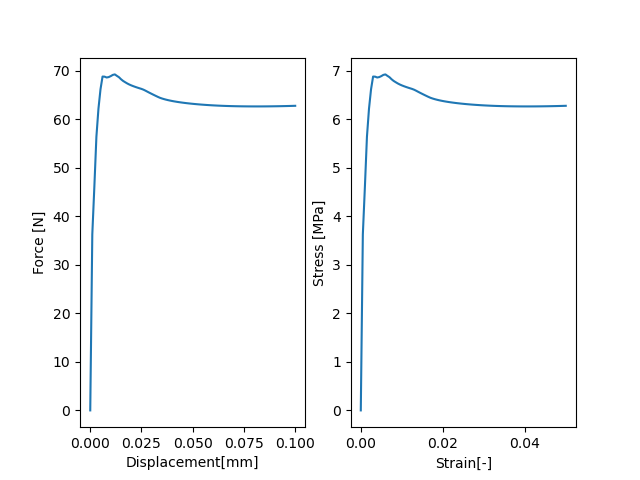

In [35]:
U_last = m.hist.U_t[-1]
F_last = m.hist.U_t[-1]
U_t = np.average(m.hist.U_t[:, bc_r_x.dofs], axis=-1)
F_t = np.sum(m.hist.F_t[:, bc_r_x.dofs], axis=-1)
fig, (ax1,ax2) = plt.subplots(1, 2)
ax1.plot(U_t, F_t)
ax1.set_ylabel('Force [N]')
ax1.set_xlabel('Displacement[mm]')
ax2.plot(U_t/size_x, F_t/(size_y*size_z))
ax2.set_ylabel('Stress [MPa]')
ax2.set_xlabel('Strain[-]')
G = np.trapz(F_t, x=U_t)/((size_z)*(size_y))*1000
G2 = np.trapz(F_t/(size_y*size_z), x=U_t/size_x)
print(G)
print(G2)

In [9]:
if True:
    mlab.options.backend = 'envisage'
    mlab.options.offscreen = False # 'envisage'
    f_strain = mlab.figure()
    scene = mlab.get_engine().scenes[-1]
    scene.name = 'stress'
    strain_viz = Viz3DTensorField(vis3d=m.hist['stress'])
    strain_viz.setup()
    strain_viz.warp_vector.filter.scale_factor = 0.1
    strain_viz.plot(s.tstep.t_n)
    mlab.show()

## Tension ligament

In [10]:
size_x = 2
size_y = 10
size_z = 1
n_e_x = 1
n_e_y = 1
n_e_x = 1

xmodel = XDomainFEGrid(coord_min=(0, 0, 0),
                       coord_max=(size_x ,size_y, size_z),
                       shape=(n_e_x, n_e_y, n_e_x),
                     integ_factor=1,
                     fets=FETS3D8H())
E = 34000

m_inelastic = MS13D(**CAxisymm)
m_elastic = MATS3DElastic(E=34000, nu=0.2)
m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [11]:
w_max = 0.01 * size_x

# Tension bc
bc_l_x = BCSlice(slice=xmodel.mesh[0, :, :, 0, :, :],
                  var='u', dims=[0], value=0.0)
bc_r_x = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[0], value=w_max)
bc_r_y = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[1], value=w_max)
bc_xy_z0 = BCSlice(slice=xmodel.mesh[:, :, 0, :, :, 0],
                  var='u', dims=[2], value=0)
bc_xz_y0 = BCSlice(slice=xmodel.mesh[:, 0, :, :, 0, :],
                 var='u', dims=[1], value=0)

In [12]:
bc1 = [bc_l_x, bc_r_x, bc_xy_z0, bc_xz_y0]

In [13]:
m.bc=bc1
m.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m.sim
s.tloop.verbose = False
s.tloop.k_max = 1000
s.tline.step = 0.01
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
s.run()

KeyboardInterrupt: 

118.9607151647798
0.059480357582389884


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
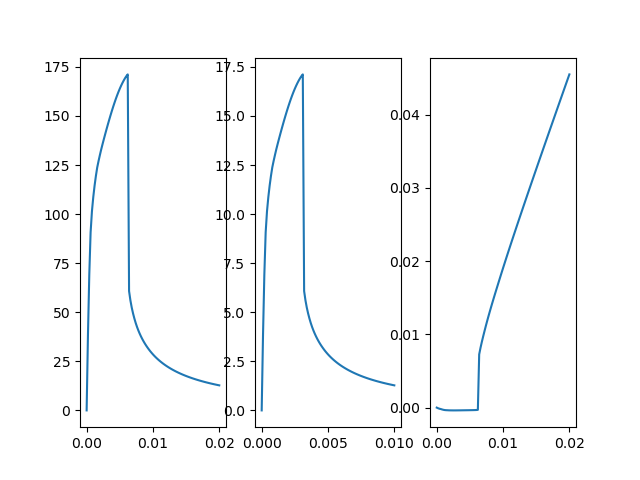

In [112]:
U_last = m.hist.U_t[-1]
F_last = m.hist.U_t[-1]
U_t = np.average(m.hist.U_t[:, bc_r_x.dofs], axis=-1)
U_t_y = np.average(m.hist.U_t[:, bc_r_y.dofs], axis=-1)
F_t = np.sum(m.hist.F_t[:, bc_r_x.dofs], axis=-1)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(U_t, F_t)
# ax1.plot(U_t_y, F_t)
ax2.plot(U_t/size_x, F_t/(size_y*size_z))
ax3.plot(U_t, U_t_y)
G = np.trapz(F_t, x=U_t)
G2 = np.trapz(F_t/(size_y*size_z), x=U_t/size_x)
print(G/((size_z)*(size_y))*1000)
print(G2)

In [113]:
if False:
    mlab.options.backend = 'envisage'
    mlab.options.offscreen = False # 'envisage'
    f_strain = mlab.figure()
    scene = mlab.get_engine().scenes[-1]
    scene.name = 'stress'
    strain_viz = Viz3DTensorField(vis3d=m.hist['stress'])
    strain_viz.setup()
    strain_viz.warp_vector.filter.scale_factor = 0.1
    strain_viz.plot(s.tstep.t_n)
    mlab.show()

In [114]:
# eps_Emab = xmodel.map_U_to_field(U_t[-1])
# m.fe_domain[0].state_k
# m_inelastic.get_corr_pred(eps_Emab, 1, **m.fe_domain[2].state_k)

## Tension bulk circumferential direction

In [25]:
size_x = 1
size_y = 10
size_z = 12.5
n_e_x = 1
n_e_y = 1
n_e_x = 1

xmodel = XDomainFEGrid(coord_min=(0, 0, 0),
                       coord_max=(size_x ,size_y, size_z),
                       shape=(n_e_x, n_e_y, n_e_x),
                     integ_factor=1,
                     fets=FETS3D8H())
E = 34000

m_inelastic = MS13D(**CAxisymm)
m_elastic = MATS3DElastic(E=34000, nu=0.2)
m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [26]:
w_max = 0.01 * size_x

# Tension bc
bc_l_x = BCSlice(slice=xmodel.mesh[0, :, :, 0, :, :],
                  var='u', dims=[0], value=0.0)
bc_r_x = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[0], value=w_max)
bc_r_y = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[1], value=w_max)
bc_xy_z0 = BCSlice(slice=xmodel.mesh[:, :, 0, :, :, 0],
                  var='u', dims=[2], value=0)
bc_xz_y0 = BCSlice(slice=xmodel.mesh[:, 0, :, :, 0, :],
                 var='u', dims=[1], value=0)

In [27]:
bc1 = [bc_l_x, bc_r_x, bc_xy_z0, bc_xz_y0]

In [28]:
m.bc=bc1
m.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m.sim
s.tloop.verbose = False
s.tloop.k_max = 1000
s.tline.step = 0.01
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
s.run()

43.45542720517216
0.043455427205172176


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
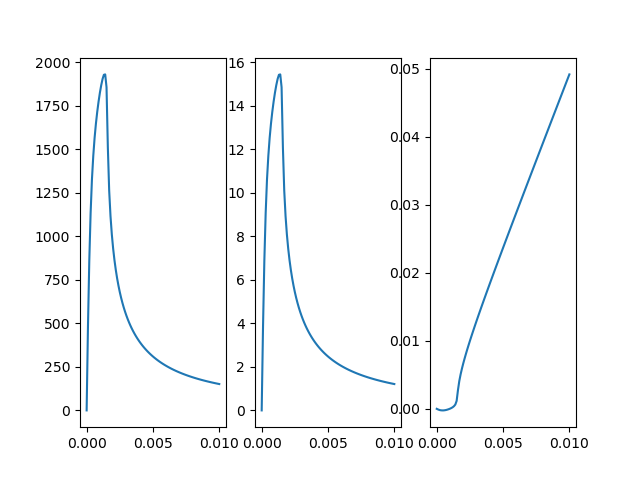

In [29]:
U_last = m.hist.U_t[-1]
F_last = m.hist.U_t[-1]
U_t = np.average(m.hist.U_t[:, bc_r_x.dofs], axis=-1)
U_t_y = np.average(m.hist.U_t[:, bc_r_y.dofs], axis=-1)
F_t = np.sum(m.hist.F_t[:, bc_r_x.dofs], axis=-1)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(U_t, F_t)
# ax1.plot(U_t_y, F_t)
ax2.plot(U_t/size_x, F_t/(size_y*size_z))
ax3.plot(U_t, U_t_y)
G = np.trapz(F_t, x=U_t)/((size_z)*(size_y))*1000
G2 = np.trapz(F_t/(size_y*size_z), x=U_t/size_x)
print(G)
print(G2)

In [31]:
if True:
    mlab.options.backend = 'envisage'
    mlab.options.offscreen = False # 'envisage'
    f_strain = mlab.figure()
    scene = mlab.get_engine().scenes[-1]
    scene.name = 'stress'
    strain_viz = Viz3DTensorField(vis3d=m.hist['stress'])
    strain_viz.setup()
    strain_viz.warp_vector.filter.scale_factor = 0.1
    strain_viz.plot(s.tstep.t_n)
    mlab.show()

In [ ]:
# eps_Emab = xmodel.map_U_to_field(U_t[-1])
# m.fe_domain[0].state_k
# m_inelastic.get_corr_pred(eps_Emab, 1, **m.fe_domain[2].state_k)

## Tension bulk radial direction

In [18]:
size_x = 12.5
size_y = 1
size_z = 10
n_e_x = 1
n_e_y = 1
n_e_x = 1

xmodel = XDomainFEGrid(coord_min=(0, 0, 0),
                       coord_max=(size_x ,size_y, size_z),
                       shape=(n_e_x, n_e_y, n_e_x),
                     integ_factor=1,
                     fets=FETS3D8H())
E = 34000

m_inelastic = MS13D(**CAxisymm)
m_elastic = MATS3DElastic(E=34000, nu=0.2)
m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [19]:
w_max = 0.01 * size_x

# Tension bc
bc_l_x = BCSlice(slice=xmodel.mesh[0, :, :, 0, :, :],
                  var='u', dims=[0], value=0.0)
bc_r_x = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[0], value=w_max)
bc_r_y = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[1], value=w_max)
bc_xy_z0 = BCSlice(slice=xmodel.mesh[:, :, 0, :, :, 0],
                  var='u', dims=[2], value=0)
bc_xz_y0 = BCSlice(slice=xmodel.mesh[:, 0, :, :, 0, :],
                 var='u', dims=[1], value=0)

In [20]:
bc1 = [bc_l_x, bc_r_x, bc_xy_z0, bc_xz_y0]

In [21]:
m.bc=bc1
m.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m.sim
s.tloop.verbose = False
s.tloop.k_max = 1000
s.tline.step = 0.01
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
s.run()

543.1915990208647
0.04345532792166917


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
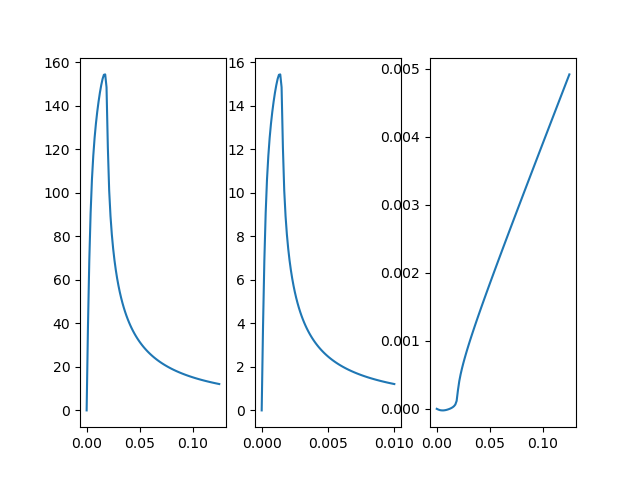

In [22]:
U_last = m.hist.U_t[-1]
F_last = m.hist.U_t[-1]
U_t = np.average(m.hist.U_t[:, bc_r_x.dofs], axis=-1)
U_t_y = np.average(m.hist.U_t[:, bc_r_y.dofs], axis=-1)
F_t = np.sum(m.hist.F_t[:, bc_r_x.dofs], axis=-1)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(U_t, F_t)
# ax1.plot(U_t_y, F_t)
ax2.plot(U_t/size_x, F_t/(size_y*size_z))
ax3.plot(U_t, U_t_y)
G = np.trapz(F_t, x=U_t)/((size_z)*(size_y))*1000
G2 = np.trapz(F_t/(size_y*size_z), x=U_t/size_x)
print(G)
print(G2)

In [24]:
if True:
    mlab.options.backend = 'envisage'
    mlab.options.offscreen = False # 'envisage'
    f_strain = mlab.figure()
    scene = mlab.get_engine().scenes[-1]
    scene.name = 'stress'
    strain_viz = Viz3DTensorField(vis3d=m.hist['stress'])
    strain_viz.setup()
    strain_viz.warp_vector.filter.scale_factor = 0.1
    strain_viz.plot(s.tstep.t_n)
    mlab.show()

In [ ]:
# eps_Emab = xmodel.map_U_to_field(U_t[-1])
# m.fe_domain[0].state_k
# m_inelastic.get_corr_pred(eps_Emab, 1, **m.fe_domain[2].state_k)

## Compression dc

In [ ]:
size_x = 2
size_y = 20
size_z = 1
n_e_x = 1
n_e_y = 2
n_e_x = 1

xmodel = XDomainFEGrid(coord_min=(0, 0, 0),
                       coord_max=(size_x ,size_y, size_z),
                       shape=(n_e_x, n_e_y, n_e_x),
                     integ_factor=1,
                     fets=FETS3D8H())
E = 34000

m_inelastic = MS13D(**CAxisymm)
m_elastic = MATS3DElastic(E=34000, nu=0.2)
m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [ ]:
w_max = -0.01 * size_x 

# Tension bc
bc_l_x = BCSlice(slice=xmodel.mesh[0, :, :, 0, :, :],
                  var='u', dims=[0], value=0.0)
bc_r_x = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[0], value=w_max)
bc_xy_z0 = BCSlice(slice=xmodel.mesh[:, :, 0, :, :, 0],
                  var='u', dims=[2], value=0)
bc_xz_y0 = BCSlice(slice=xmodel.mesh[:, 0, :, :, 0, :],
                 var='u', dims=[1], value=0)

In [ ]:
xmodel.mesh[:, :, :, :, :, 0].dofs

In [ ]:
bc1 = [bc_l_x, bc_r_x, bc_xy_z0, bc_xz_y0]

In [ ]:
m.bc=bc1
m.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m.sim
s.tloop.verbose = True
s.tloop.k_max = 1000
s.tline.step = 0.01
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
s.run()

In [ ]:
U_last = m.hist.U_t[-1]
F_last = m.hist.U_t[-1]
U_t = np.average(m.hist.U_t[:, bc_r_x.dofs], axis=-1)
F_t = np.sum(m.hist.F_t[:, bc_r_x.dofs], axis=-1)
fig, (ax1,ax2) = plt.subplots(1, 2)
ax1.plot(-U_t, -F_t)
ax2.plot(-U_t/size_x, -F_t/(size_y*size_z))
G = np.trapz(F_t, x=U_t)
print(G/((size_z)*(size_y))*1000)

In [ ]:
if False:
    mlab.options.backend = 'envisage'
    mlab.options.offscreen = False # 'envisage'
    f_strain = mlab.figure()
    scene = mlab.get_engine().scenes[-1]
    scene.name = 'stress'
    strain_viz = Viz3DTensorField(vis3d=m.hist['stress'])
    strain_viz.setup()
    strain_viz.warp_vector.filter.scale_factor = 0.1
    strain_viz.plot(s.tstep.t_n)
    mlab.show()

## Shear dc + Compression fc

In [ ]:
size_x = 2
size_y = 20
size_z = 1
n_e_x = 1
n_e_y = 2
n_e_x = 1

xmodel = XDomainFEGrid(coord_min=(0, 0, 0),
                       coord_max=(size_x ,size_y, size_z),
                       shape=(n_e_x, n_e_y, n_e_x),
                     integ_factor=1,
                     fets=FETS3D8H())
E = 34000

m_inelastic = MS13D(**CAxisymm)
m_elastic = MATS3DElastic(E=34000, nu=0.2)
m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [ ]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=0.1)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=0.1)

In [ ]:
w_max = 0.05 

# Shear bc
bc_l_x = BCSlice(slice=xmodel.mesh[0, :, :, 0, :, :],
                  var='u', dims=[0,1,2], value=0.0)

slide_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[1], value=w_max)
slide_dofs = slide_slice.dofs
slide = [BCDof(var='u', dof=dof, value=w_max , time_function=tf_sliding) 
                     for dof in slide_dofs ]


compression_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[0], value=-w_max/100)
compression_dofs = compression_slice.dofs
compression_force = -1 * (size_y*size_z) / len(compression_dofs)
compression_force_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in compression_dofs ]


In [ ]:
bc1 = [bc_l_x]  + slide + compression_force_first

In [ ]:
m.bc=bc1
m.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m.sim
s.tloop.verbose = True
s.tloop.k_max = 1000
s.tline.step = 0.05
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
s.run()

In [ ]:
U_last = m.hist.U_t[-1]
F_last = m.hist.U_t[-1]
U_t = np.average(m.hist.U_t[:, slide_dofs], axis=-1)
F_t = np.sum(m.hist.F_t[:, slide_dofs], axis=-1)
F_t_c = np.sum(m.hist.F_t[:, compression_dofs], axis=-1)
fig, ax = plt.subplots(1, 1)
ax.plot(U_t, F_t)
ax.plot(U_t, F_t_c)

In [ ]:
if True:
    mlab.options.backend = 'envisage'
    mlab.options.offscreen = False # 'envisage'
    f_strain = mlab.figure()
    scene = mlab.get_engine().scenes[-1]
    scene.name = 'stress'
    strain_viz = Viz3DTensorField(vis3d=m.hist['stress'])
    strain_viz.setup()
    strain_viz.warp_vector.filter.scale_factor = 0.1
    strain_viz.plot(s.tstep.t_n)
    mlab.show()

## MDM calibration

In [45]:
from traits.api import \
    Constant, \
    Float, Property, cached_property

class PhiFnStrainSoftening():

    '''
    Damage function.
    '''


    G_f = Float(0.035,
                label='G_f',
                desc='fracture energy',
                auto_set=False, enter_set=True)
    f_t = Float(16,
                label='f_t',
                desc='tensile strength',
                auto_set=False, enter_set=True)
    md = Float(0.0,
               label='md',
               desc='factor affecting the compresive strength (explain more precisely)',
               auto_set=False, enter_set=True)
    h = Float(20.0,
              label='h',
              desc='element size to norm the fracture energy',
              auto_set=False, enter_set=True)
    E = Float(40000.0,
              label='h',
              desc='element size to norm the fracture energy',
              auto_set=False, enter_set=True)

    Epp = Float(
        desc='strain at the onset of damage', enter_set=True, auto_set=False)
    Efp = Float(desc='strain at total damaged', enter_set=True, auto_set=False)

    def fit_microplane_params(self):
        '''
        Calculate the parameters of the damage function
        '''

        E = self.E
        G_f = self.G_f
        f_t = self.f_t
        md = self.md
        h = self.h

        gamma = (E * G_f) / (h * f_t ** 2)
        if gamma < 2.0:
            print ('WARNING: elements too big -> refine, h should be at maximum only half of the characteristic length')
            print ('in FIT PARAMS: gamma set to 2.0')
            gamma = 2.0

        Epp = f_t / \
            ((E * (1 - md) ** 2) * (1.95 - 0.95 / (gamma - 1) ** (0.5)))
        Efp = (G_f / ((1 - md) * h * E * Epp) +
               (2.13 - 1.13 * md) * Epp) / (2.73 - md) - Epp
        self.Epp = Epp
        self.Efp = Efp

In [46]:
# CAxisymmMDM = dict(
#     epsilon_0 = 200.0e-6,
#     epsilon_f = 2000.0e-6,
#     c_T = 0.02,
#     E = 42000,
#     nu = 0.18
# )

CAxisymmMDM = dict(
    epsilon_0 = 59.0e-6,
    epsilon_f = 250.0e-6,
    c_T = 0.02,
    E = 42000,
    nu = 0.18
)


In [47]:
CAxisymm = dict(
    E = 42e+3,
    nu = 0.2,
    Ad = 300.0,
    eps_0 = 0.00001,
    K_N = 17000.,
    sigma_N_0 = 45.,
    gamma_N = 9000.,
    sigma_T_0 = 3.0,
    K_T = 20000.0,
    gamma_T = 50000,
    S_T = 0.000075,
    c_T = 2.,
    r_T = 2.,
    m_T = 0.1,
    p_T = 1.
)

## Tension bulk circumferential direction

In [54]:
size_x = 1
size_y = 10
size_z = 12.5
n_e_x = 1
n_e_y = 1
n_e_x = 1

xmodel = XDomainFEGrid(coord_min=(0, 0, 0),
                       coord_max=(size_x ,size_y, size_z),
                       shape=(n_e_x, n_e_y, n_e_x),
                     integ_factor=1,
                     fets=FETS3D8H())
E = 34000

m_inelastic = MATS3DMplDamageEEQ(**CAxisymmMDM)
# m_inelastic = MS13D(**CAxisymm)

m_elastic = MATS3DElastic(E=34000, nu=0.2)
m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [55]:
w_max = 0.01 * size_x

# Tension bc
bc_l_x = BCSlice(slice=xmodel.mesh[0, :, :, 0, :, :],
                  var='u', dims=[0], value=0.0)
bc_r_x = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[0], value=w_max)
bc_xy_z0 = BCSlice(slice=xmodel.mesh[:, :, 0, :, :, 0],
                  var='u', dims=[2], value=0)
bc_xz_y0 = BCSlice(slice=xmodel.mesh[:, 0, :, :, 0, :],
                 var='u', dims=[1], value=0)

In [56]:
bc1 = [bc_l_x, bc_r_x, bc_xy_z0, bc_xz_y0]

In [57]:
m.bc=bc1
m.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m.sim
s.tloop.verbose = False
s.tloop.k_max = 1000
s.tline.step = 0.01
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
s.run()

3.4015402650738937
0.003401540265073893


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
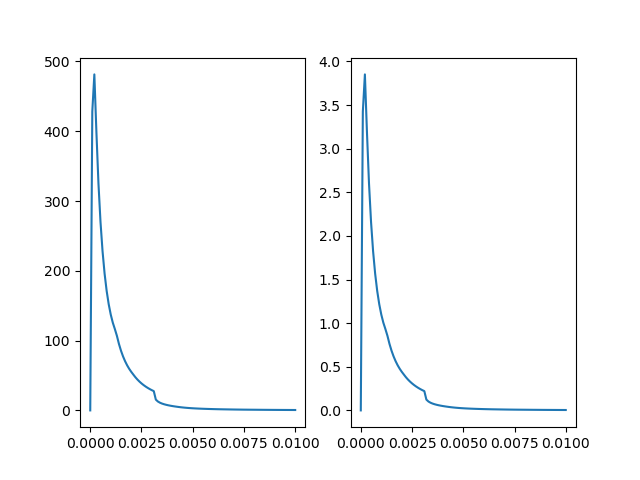

In [58]:
U_last = m.hist.U_t[-1]
F_last = m.hist.U_t[-1]
U_t = np.average(m.hist.U_t[:, bc_r_x.dofs], axis=-1)
F_t = np.sum(m.hist.F_t[:, bc_r_x.dofs], axis=-1)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(U_t, F_t)
# ax1.plot(U_t_2, F_t_2)
ax2.plot(U_t/size_x, F_t/(size_y*size_z))
# ax2.plot(U_t_2/size_x, F_t_2/(size_y*size_z))
G = np.trapz(F_t, x=U_t)
G2 = np.trapz(F_t/(size_y*size_z), x=U_t/size_x)
print(G/((size_z)*(size_y))*1000)
print(G2)

In [ ]:
# m.hist.F_t[:, bc_r_x.dofs]
# bc_r_x.dofs

In [ ]:
# eps_Emab = xmodel.map_U_to_field(U_last)
# eps_Emab

In [ ]:
if False:
    mlab.options.backend = 'envisage'
    mlab.options.offscreen = False # 'envisage'
    f_strain = mlab.figure()
    scene = mlab.get_engine().scenes[-1]
    scene.name = 'stress'
    strain_viz = Viz3DTensorField(vis3d=m.hist['stress'])
    strain_viz.setup()
    strain_viz.warp_vector.filter.scale_factor = 0.1
    strain_viz.plot(s.tstep.t_n)
    mlab.show()

In [ ]:
# eps_Emab = xmodel.map_U_to_field(U_t[-1])
m.fe_domain[0].state_k
# m_inelastic.get_corr_pred(eps_Emab, 1, **m.fe_domain[2].state_k)

## Tension bulk radial direction

In [59]:
size_x = 12.5
size_y = 1
size_z = 10
n_e_x = 1
n_e_y = 1
n_e_x = 1

xmodel = XDomainFEGrid(coord_min=(0, 0, 0),
                       coord_max=(size_x ,size_y, size_z),
                       shape=(n_e_x, n_e_y, n_e_x),
                     integ_factor=1,
                     fets=FETS3D8H())
E = 34000

m_inelastic = MATS3DMplDamageEEQ(**CAxisymmMDM)
# m_inelastic = MS13D(**CAxisymm)

m_elastic = MATS3DElastic(E=34000, nu=0.2)
m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [60]:
w_max = 0.01 * size_x

# Tension bc
bc_l_x = BCSlice(slice=xmodel.mesh[0, :, :, 0, :, :],
                  var='u', dims=[0], value=0.0)
bc_r_x = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[0], value=w_max)
bc_xy_z0 = BCSlice(slice=xmodel.mesh[:, :, 0, :, :, 0],
                  var='u', dims=[2], value=0)
bc_xz_y0 = BCSlice(slice=xmodel.mesh[:, 0, :, :, 0, :],
                 var='u', dims=[1], value=0)

In [61]:
bc1 = [bc_l_x, bc_r_x, bc_xy_z0, bc_xz_y0]

In [62]:
m.bc=bc1
m.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m.sim
s.tloop.verbose = False
s.tloop.k_max = 1000
s.tline.step = 0.01
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
s.run()

47.69876933342897
0.0038159015466743174


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
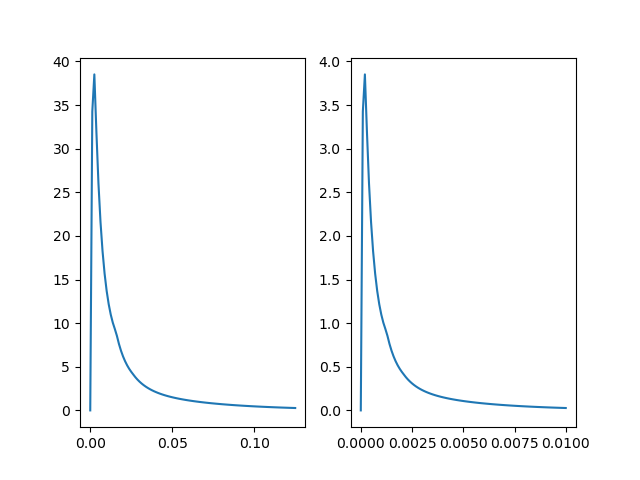

In [63]:
U_last = m.hist.U_t[-1]
F_last = m.hist.U_t[-1]
U_t = np.average(m.hist.U_t[:, bc_r_x.dofs], axis=-1)
F_t = np.sum(m.hist.F_t[:, bc_r_x.dofs], axis=-1)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(U_t, F_t)
# ax1.plot(U_t_2, F_t_2)
ax2.plot(U_t/size_x, F_t/(size_y*size_z))
# ax2.plot(U_t_2/size_x, F_t_2/(size_y*size_z))
G = np.trapz(F_t, x=U_t)
G2 = np.trapz(F_t/(size_y*size_z), x=U_t/size_x)
print(G/((size_z)*(size_y))*1000)
print(G2)

In [ ]:
# m.hist.F_t[:, bc_r_x.dofs]
# bc_r_x.dofs

In [ ]:
# eps_Emab = xmodel.map_U_to_field(U_last)
# eps_Emab

In [ ]:
if False:
    mlab.options.backend = 'envisage'
    mlab.options.offscreen = False # 'envisage'
    f_strain = mlab.figure()
    scene = mlab.get_engine().scenes[-1]
    scene.name = 'stress'
    strain_viz = Viz3DTensorField(vis3d=m.hist['stress'])
    strain_viz.setup()
    strain_viz.warp_vector.filter.scale_factor = 0.1
    strain_viz.plot(s.tstep.t_n)
    mlab.show()

In [ ]:
# eps_Emab = xmodel.map_U_to_field(U_t[-1])
m.fe_domain[0].state_k
# m_inelastic.get_corr_pred(eps_Emab, 1, **m.fe_domain[2].state_k)

## Compression dc

In [ ]:
size_x = 1
size_y = 20
size_z = 12.5
n_e_x = 1
n_e_y = 1
n_e_x = 1

xmodel = XDomainFEGrid(coord_min=(0, 0, 0),
                       coord_max=(size_x ,size_y, size_z),
                       shape=(n_e_x, n_e_y, n_e_x),
                     integ_factor=1,
                     fets=FETS3D8H())
E = 34000

m_inelastic = MATS3DMplDamageEEQ(**CAxisymmMDM)
m_elastic = MATS3DElastic(E=34000, nu=0.2)
m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [ ]:
w_max = -0.01 * size_x 

# Tension bc
bc_l_x = BCSlice(slice=xmodel.mesh[0, :, :, 0, :, :],
                  var='u', dims=[0], value=0.0)
bc_r_x = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[0], value=w_max)
bc_xy_z0 = BCSlice(slice=xmodel.mesh[:, :, 0, :, :, 0],
                  var='u', dims=[2], value=0)
bc_xz_y0 = BCSlice(slice=xmodel.mesh[:, 0, :, :, 0, :],
                 var='u', dims=[1], value=0)

In [ ]:
xmodel.mesh[:, :, :, :, :, 0].dofs

In [ ]:
bc1 = [bc_l_x, bc_r_x, bc_xy_z0, bc_xz_y0]

In [ ]:
m.bc=bc1
m.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m.sim
s.tloop.verbose = False
s.tloop.k_max = 1000
s.tline.step = 0.01
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
s.run()

In [ ]:
U_last = m.hist.U_t[-1]
F_last = m.hist.U_t[-1]
U_t = np.average(m.hist.U_t[:, bc_r_x.dofs], axis=-1)
F_t = np.sum(m.hist.F_t[:, bc_r_x.dofs], axis=-1)
fig, (ax1,ax2) = plt.subplots(1, 2)
ax1.plot(-U_t, -F_t)
ax2.plot(-U_t/size_x, -F_t/(size_y*size_z))
G = np.trapz(F_t, x=U_t)
print(G/((size_z)*(size_y))*1000)

In [ ]:
if False:
    mlab.options.backend = 'envisage'
    mlab.options.offscreen = False # 'envisage'
    f_strain = mlab.figure()
    scene = mlab.get_engine().scenes[-1]
    scene.name = 'stress'
    strain_viz = Viz3DTensorField(vis3d=m.hist['stress'])
    strain_viz.setup()
    strain_viz.warp_vector.filter.scale_factor = 0.1
    strain_viz.plot(s.tstep.t_n)
    mlab.show()

## Shear dc

In [ ]:
size_x = 1
size_y = 20
size_z = 12.5
n_e_x = 1
n_e_y = 1
n_e_x = 1

xmodel = XDomainFEGrid(coord_min=(0, 0, 0),
                       coord_max=(size_x ,size_y, size_z),
                       shape=(n_e_x, n_e_y, n_e_x),
                     integ_factor=1,
                     fets=FETS3D8H())
E = 34000

m_inelastic = MATS3DMplDamageEEQ(**CAxisymmMDM)
m_elastic = MATS3DElastic(E=34000, nu=0.2)
m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [ ]:
w_max = 0.0025 * size_y

# Shear bc
bc_l_x = BCSlice(slice=xmodel.mesh[0, :, :, 0, :, :],
                  var='u', dims=[0,1,2], value=0.0)
bc_r_x = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[1], value=w_max)
bc_r_x_2 = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[0], value=0.0)

In [ ]:
xmodel.mesh[:, :, :, :, :, 0].dofs

In [ ]:
bc1 = [bc_l_x, bc_r_x,bc_r_x_2]

In [ ]:
m.bc=bc1
m.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m.sim
s.tloop.verbose = False
s.tloop.k_max = 1000
s.tline.step = 0.01
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
s.run()

In [ ]:
U_last = m.hist.U_t[-1]
F_last = m.hist.U_t[-1]
U_t = np.average(m.hist.U_t[:, bc_r_x.dofs], axis=-1)
F_t = np.sum(m.hist.F_t[:, bc_r_x.dofs], axis=-1)
fig, (ax1,ax2) = plt.subplots(1, 2)
ax1.plot(U_t, F_t)
ax2.plot(U_t/size_x, F_t/(size_y*size_z))
G = np.trapz(F_t, x=U_t)
print(G/((size_z)*(size_y))*1000)

In [ ]:
if False:
    mlab.options.backend = 'envisage'
    mlab.options.offscreen = False # 'envisage'
    f_strain = mlab.figure()
    scene = mlab.get_engine().scenes[-1]
    scene.name = 'stress'
    strain_viz = Viz3DTensorField(vis3d=m.hist['stress'])
    strain_viz.setup()
    strain_viz.warp_vector.filter.scale_factor = 0.1
    strain_viz.plot(s.tstep.t_n)
    mlab.show()

## Shear dc + Compression fc

In [ ]:
size_x = 2
size_y = 20
size_z = 1
n_e_x = 1
n_e_y = 2
n_e_x = 1

xmodel = XDomainFEGrid(coord_min=(0, 0, 0),
                       coord_max=(size_x ,size_y, size_z),
                       shape=(n_e_x, n_e_y, n_e_x),
                     integ_factor=1,
                     fets=FETS3D8H())
E = 34000

m_inelastic = MS13D(**CAxisymm)
m_elastic = MATS3DElastic(E=34000, nu=0.2)
m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [ ]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=0.1)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=0.1)

In [ ]:
w_max = 0.05 

# Shear bc
bc_l_x = BCSlice(slice=xmodel.mesh[0, :, :, 0, :, :],
                  var='u', dims=[0,1,2], value=0.0)

slide_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[1], value=w_max)
slide_dofs = slide_slice.dofs
slide = [BCDof(var='u', dof=dof, value=w_max , time_function=tf_sliding) 
                     for dof in slide_dofs ]


compression_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[0], value=-w_max/100)
compression_dofs = compression_slice.dofs
compression_force = -1 * (size_y*size_z) / len(compression_dofs)
compression_force_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in compression_dofs ]


In [ ]:
bc1 = [bc_l_x]  + slide + compression_force_first

In [ ]:
m.bc=bc1
m.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m.sim
s.tloop.verbose = True
s.tloop.k_max = 1000
s.tline.step = 0.05
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
s.run()

In [ ]:
U_last = m.hist.U_t[-1]
F_last = m.hist.U_t[-1]
U_t = np.average(m.hist.U_t[:, slide_dofs], axis=-1)
F_t = np.sum(m.hist.F_t[:, slide_dofs], axis=-1)
F_t_c = np.sum(m.hist.F_t[:, compression_dofs], axis=-1)
fig, ax = plt.subplots(1, 1)
ax.plot(U_t, F_t)
ax.plot(U_t, F_t_c)

In [ ]:
if True:
    mlab.options.backend = 'envisage'
    mlab.options.offscreen = False # 'envisage'
    f_strain = mlab.figure()
    scene = mlab.get_engine().scenes[-1]
    scene.name = 'stress'
    strain_viz = Viz3DTensorField(vis3d=m.hist['stress'])
    strain_viz.setup()
    strain_viz.warp_vector.filter.scale_factor = 0.1
    strain_viz.plot(s.tstep.t_n)
    mlab.show()